<a href="https://colab.research.google.com/github/GulsumSayin/OSCC-Histopathology-Classification/blob/main/OSCC_InceptionResnetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Remove image import here
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Veri Setinin Alınması

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri klasörleri
base_dir = "/content/drive/MyDrive/final_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Ayarlar
image_size = (224, 224)
batch_size = 32

# Train için augmentasyon + normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Val ve test: sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Veri yükleyiciler
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Test için önemli
)

# Kontrol
print("✅ Train sınıfları:", train_data.class_indices)
print("✅ Val sınıfları:", val_data.class_indices)
print("✅ Test sınıfları:", test_data.class_indices)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
✅ Train sınıfları: {'normal': 0, 'oscc': 1}
✅ Val sınıfları: {'normal': 0, 'oscc': 1}
✅ Test sınıfları: {'normal': 0, 'oscc': 1}


#### Modelin Oluşturulması

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

def build_inceptionresnet(input_shape=(224, 224, 3)):
    base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = True
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(base.input, output)

model=build_inceptionresnet()
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,730,465 (208.78 MB)

 Trainable params: 54,669,921 (208.55 MB)

 Non-trainable params: 60,544 (236.50 KB)

**Modelin Derlenmesi**

In [ ]:
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.05),  # 🔁 label smoothing eklenebilir
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau: val_loss durursa lr'i azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Erken durdurma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

callbacks = [early_stop,reduce_lr]

#### Model Eğitimi

In [ ]:
# 🏋️‍♂️ Model eğitimi
history_1 = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 824s 9s/step - accuracy: 0.7040 - loss: 0.5650 - precision: 0.7212 - recall: 0.6228 - val_accuracy: 0.7467 - val_loss: 0.8295 - val_precision: 1.0000 - val_recall: 0.4933 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9158 - loss: 0.2903 - precision: 0.9269 - recall: 0.9046 - val_accuracy: 0.9133 - val_loss: 0.4301 - val_precision: 0.9844 - val_recall: 0.8400 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9410 - loss: 0.2343 - precision: 0.9383 - recall: 0.9440 - val_accuracy: 0.8600 - val_loss: 0.4864 - val_precision: 0.9909 - val_recall: 0.7267 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9688 - loss: 0.1886 - precision: 0.9789 - recall: 0.9578 - val_accuracy: 0.9367 - val_loss: 0.2404 - val_precision: 0.9852 - val_recall: 0.8867 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step -

#### Eğitimin Görselleştirilmesi

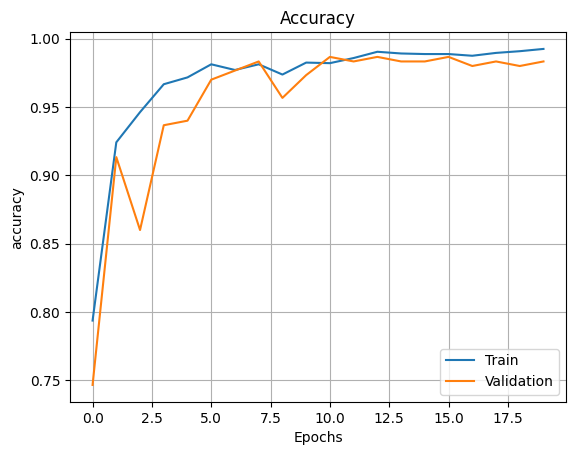

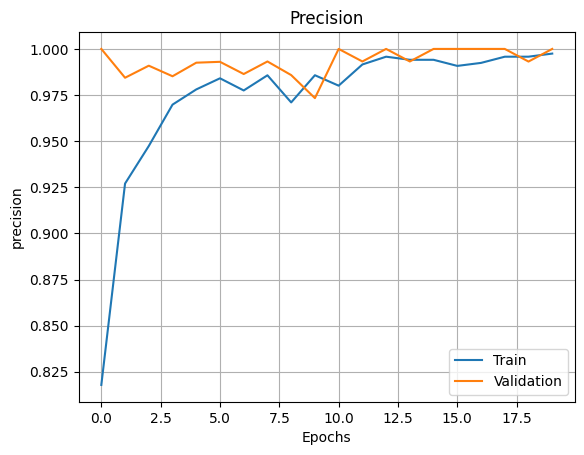

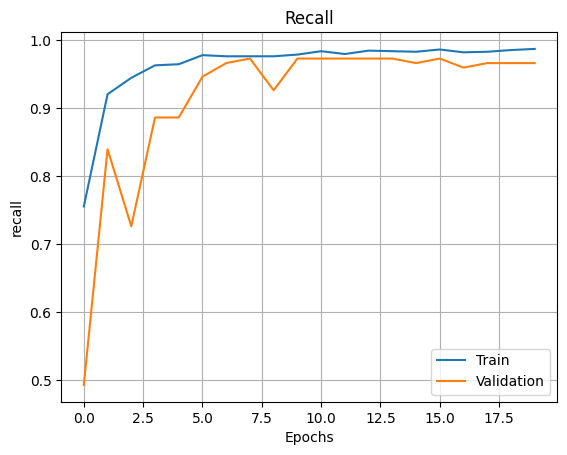

In [ ]:
# Eğitim metriklerini görselleştir
def plot_training(history):
    metrics = ['accuracy', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Validation')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history_1)

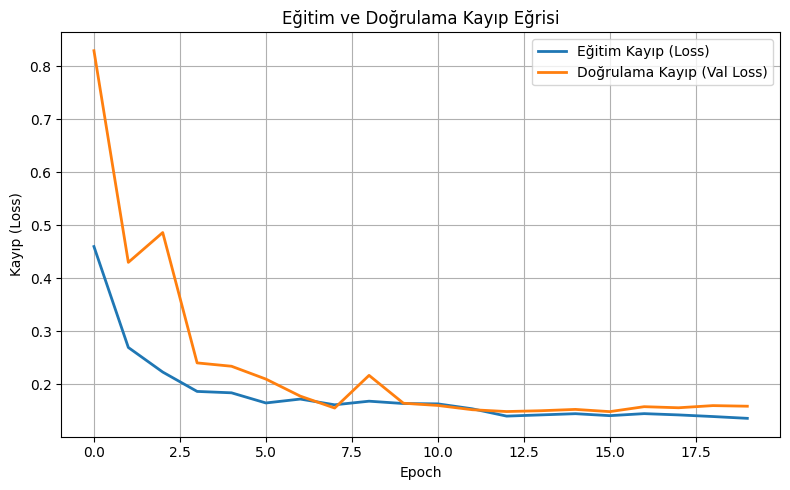

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)', linewidth=2)
    plt.title('Eğitim ve Doğrulama Kayıp Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(history_1)

#### Modelin Test Edilmesi

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 118s 11s/step
Optimal threshold: 0.1222512


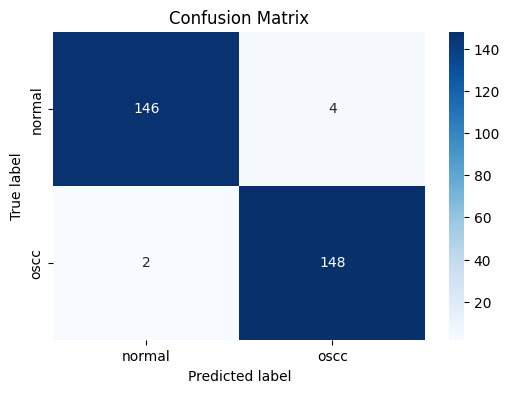

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.99      0.97      0.98       150
        oscc       0.97      0.99      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

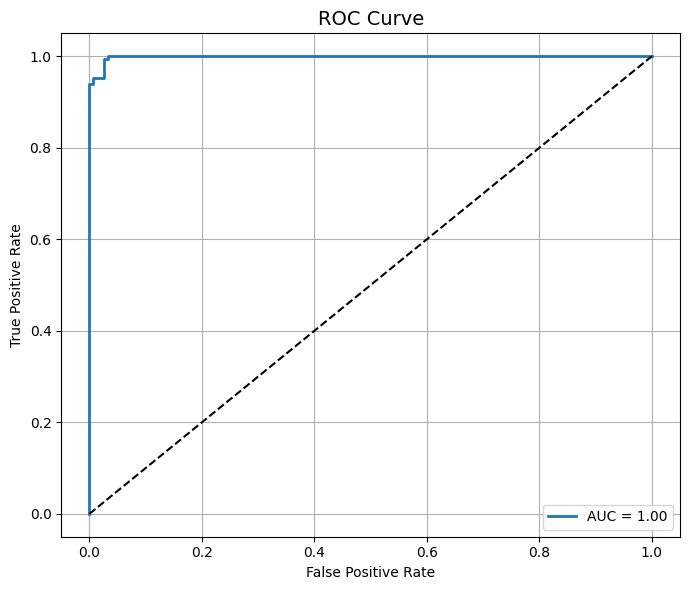

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa Skoru:", kappa)

Cohen's Kappa Skoru: 0.96


**Modelin Kaydedilmesi**

In [ ]:
model.save('/content/drive/MyDrive/inception_resnet_model.keras')

#### Grad CAM

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv_7b_ac", pred_index=None):
    """
    img_array: (1,H,W,3), [0,1] normalize edilmiş giriş.
    last_conv_layer_name: InceptionResNetV2 için iyi aday: 'conv_7b_ac'
                          (olmazsa 'conv_7b' ya da 'block8_10_ac' denenebilir)
    """
    # 1) Hedef katman
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # 2) Grad model (tekil tensörler kullan → uyarı yok)
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)

        # Nadir durumlarda liste gelebilir
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        preds = tf.convert_to_tensor(preds)

        # Binary model → hedef skor = tek nöron
        if pred_index is None:
            class_channel = preds[:, 0]
        else:
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)

    # 3) Kanal başına global ortalama (ağırlıklar)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    # 4) Ağırlıkları uygula → ReLU → normalize
    conv_outputs = conv_outputs[0]                         # (H,W,C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-12)

    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name="conv_7b_ac", alpha=0.5, target_size=(224,224)):
    # 1) Görseli yükle ve [0,1] normalize et (eğitimle uyumlu)
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 2) Isı haritası
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

    # 3) Orijinale bindirme
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (target_size[1], target_size[0]))
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 1 - alpha, heatmap_colored, alpha, 0)

    # 4) Göster
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Grad-CAM (layer: {last_conv_layer_name})", y=1.02)
    plt.subplot(1,3,1); plt.title("Original");     plt.imshow(img_cv[..., ::-1]); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Grad-CAM");     plt.imshow(heatmap, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Superimposed"); plt.imshow(superimposed[..., ::-1]); plt.axis("off")
    plt.tight_layout(); plt.show()

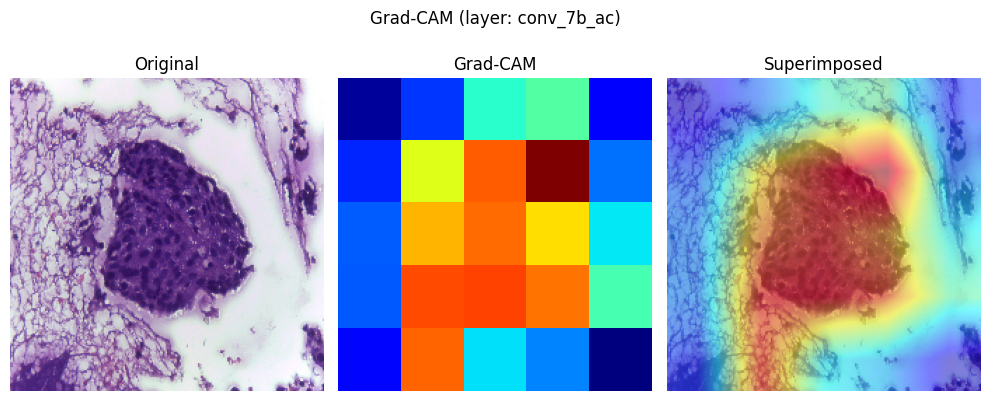

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
display_gradcam(img_path, model, last_conv_layer_name="conv_7b_ac")
# display_gradcam(img_path, model, last_conv_layer_name="conv_7b")
# display_gradcam(img_path, model, last_conv_layer_name="block8_10_ac")

#### Integrated Gradients

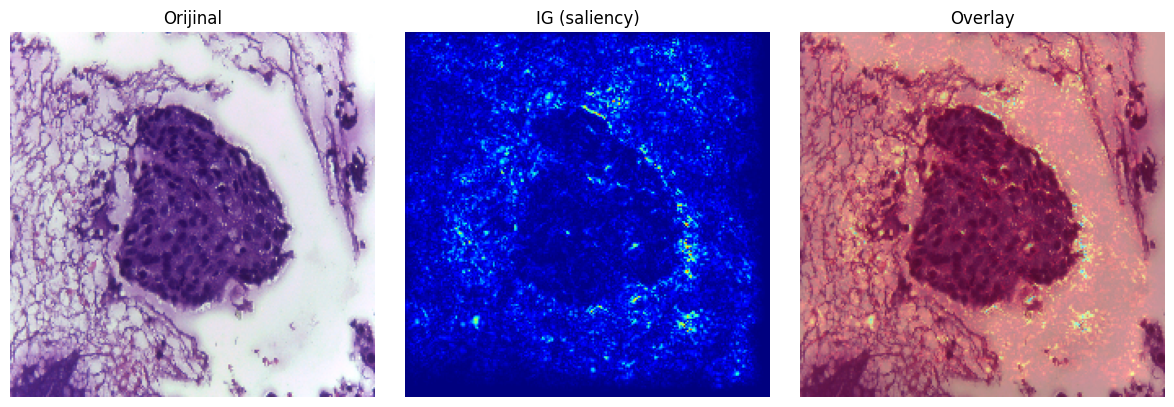

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# --- Yardımcılar ---
@tf.function
def compute_gradients(images):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images, training=False)  # önemli: training=False
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        output = preds[:, 0]  # binary: tek nöron
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, img_batch, m_steps=50, method="trapezoid"):
    # baseline ve img_batch şekilleri: (1, H, W, 3)
    alphas = tf.linspace(0.0, 1.0, m_steps)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = img_batch - baseline
    interpolated = baseline + alphas_x * delta   # (m, H, W, 3)

    grads = compute_gradients(interpolated)      # (m, H, W, 3)

    if method == "trapezoid" and m_steps > 1:
        grads = (grads[1:] + grads[:-1]) / 2.0   # trapez yaklaşımı

    avg_grads = tf.reduce_mean(grads, axis=0).numpy()      # (H, W, 3)
    integrated = (img_batch.numpy()[0] - baseline.numpy()[0]) * avg_grads  # (H,W,3)
    return integrated

def visualize_ig(img_path, target_size=(224,224), m_steps=50, baseline_type="black", save_path=None):
    # 1) görseli yükle
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    img_batch = np.expand_dims(img_arr, axis=0) / 255.0

    # 2) baseline seç
    if baseline_type == "black":
        baseline = tf.zeros_like(img_batch)
    elif baseline_type == "white":
        baseline = tf.ones_like(img_batch)
    elif baseline_type == "blur":
        # basit blur baseline
        blurred = cv2.GaussianBlur(img_arr, (51,51), 0) / 255.0
        baseline = tf.convert_to_tensor(np.expand_dims(blurred, 0), dtype=tf.float32)
    else:
        raise ValueError("baseline_type 'black' | 'white' | 'blur' olmalı.")

    # 3) IG hesapla
    ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch, dtype=tf.float32),
                              m_steps=m_steps, method="trapezoid")

    # 4) tek kanal önem haritası (abs ve normalize)
    attr = np.mean(np.abs(ig), axis=-1)
    attr -= attr.min()
    attr /= (attr.max() + 1e-12)

    # 5) görselleştir
    heatmap = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_arr.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Orijinal");     plt.imshow(img_arr.astype(np.uint8)); plt.axis("off")
    plt.subplot(1,3,2); plt.title("IG (saliency)"); plt.imshow(attr, cmap="jet");         plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay");       plt.imshow(overlay);                  plt.axis("off")
    plt.tight_layout(); plt.show()

    if save_path is not None:
        cv2.imwrite(save_path, overlay[..., ::-1])  # BGR yazdığı için ters çeviriyoruz
        print("Kaydedildi ->", save_path)

# --- KULLANIM ---
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)  # ör: save_path="/content/ig_overlay.png"

**Modelin Yüklenmesi**

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/inception_resnet_model.keras")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/inception_resnet_model.keras")

# Derleme gerekiyorsa:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Değerlendirme (örnek olarak test_data ile)
results = model.evaluate(test_data)
print(f"\nTest Sonuçları:\n  Loss: {results[0]:.4f}\n  Accuracy: {results[1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 163s 15s/step - accuracy: 0.9857 - loss: 0.0569

Test Sonuçları:
  Loss: 0.0828
  Accuracy: 0.9667


In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Optimal threshold: 0.1222512


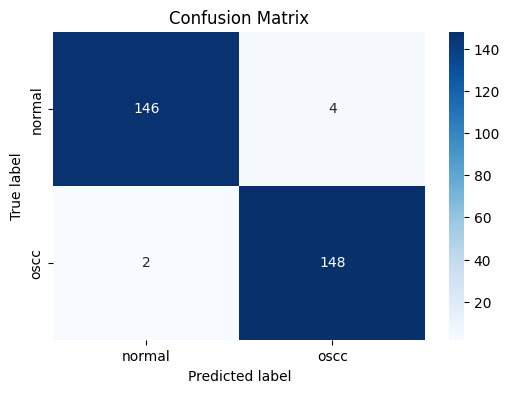

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.99      0.97      0.98       150
        oscc       0.97      0.99      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

#img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"  # örnek yol
#img_path="/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
img_array = img_array / 255.0  # Normalize

In [ ]:
pred_prob = model.predict(img_array)[0][0]

threshold = optimal_threshold  # veya ROC ile optimize ettiğin değer
pred_label = "OSCC" if pred_prob > threshold else "Normal"

print(f"Model çıktısı (olasılık): {pred_prob:.4f}")
print(f"Tahmin edilen sınıf: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Model çıktısı (olasılık): 0.9847
Tahmin edilen sınıf: OSCC


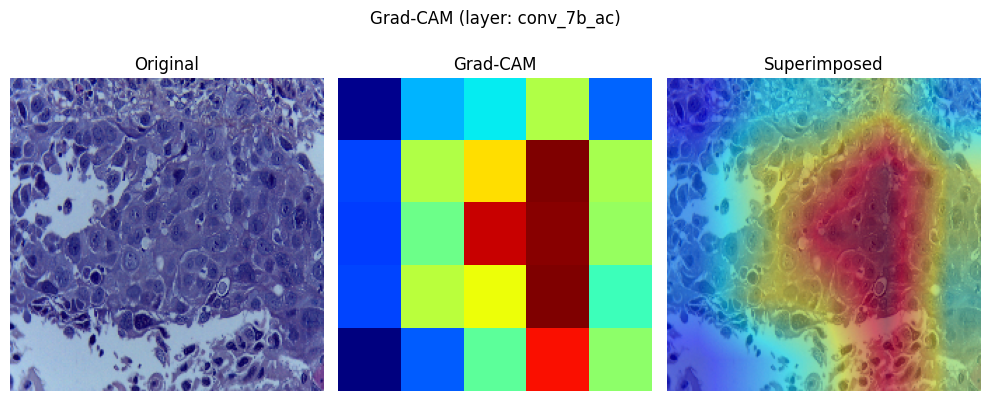

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"
display_gradcam(img_path, model, last_conv_layer_name='conv_7b_ac')

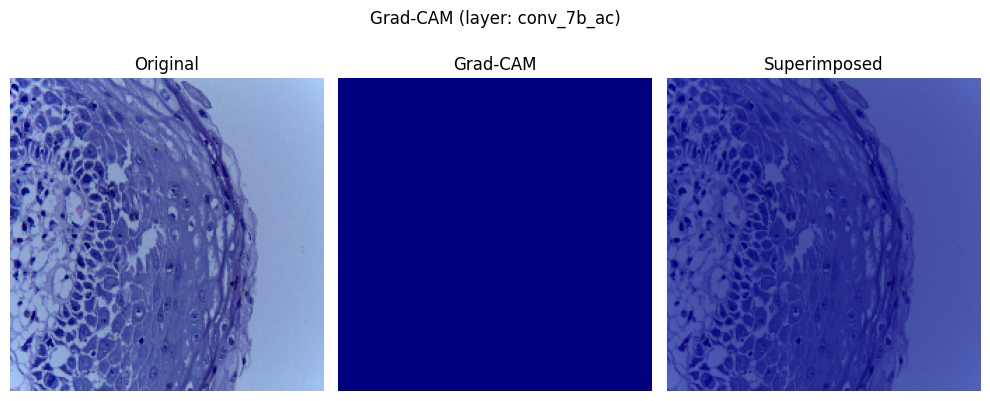

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
display_gradcam(img_path, model, last_conv_layer_name='conv_7b_ac')

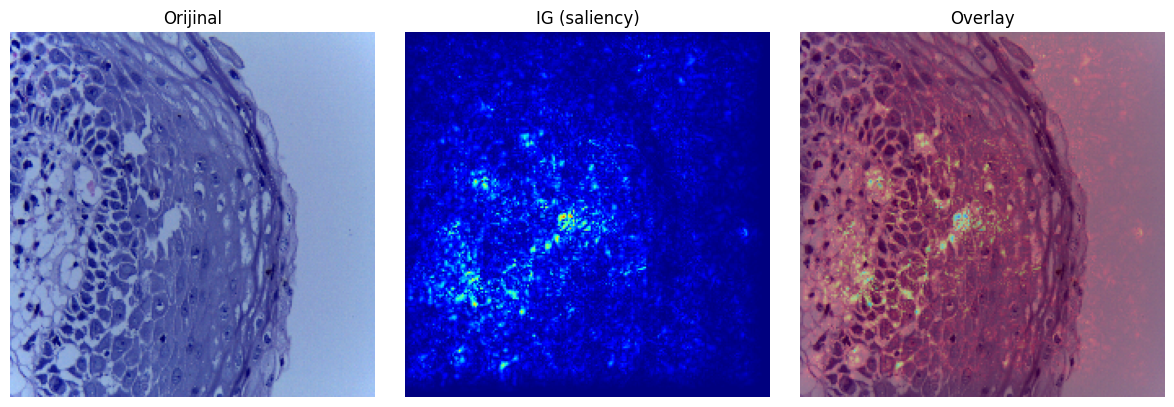

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)